In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [6]:
columns = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']
df = df[columns]

In [7]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [9]:
len(df_train), len(df_test), len(df_val)

(27126, 9043, 9042)

In [12]:
from sklearn.metrics import roc_auc_score

# Define the target variable (whether the client has subscribed to a term deposit)
y_train = df_train['y']

# Numerical features to evaluate
numerical_features = ['balance', 'day', 'duration', 'previous']

# Store the highest AUC and the corresponding feature
highest_auc = 0
best_feature = None

# Iterate over each numerical feature
for feature in numerical_features:
    # Calculate AUC for the feature
    auc = roc_auc_score(y_train, df_train[feature])
    
    # If AUC < 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    
    print(f"AUC for {feature}: {auc}")
    
    # Update the best feature if current AUC is higher
    if auc > highest_auc:
        highest_auc = auc
        best_feature = feature

# Print the feature with the highest AUC
print(f"\nThe numerical variable with the highest AUC is: {best_feature} with AUC = {highest_auc}")


AUC for balance: 0.5916931412945473
AUC for day: 0.5291275984648961
AUC for duration: 0.8128648066681694
AUC for previous: 0.5986704105715122

The numerical variable with the highest AUC is: duration with AUC = 0.8128648066681694


In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Step 1: Prepare the data for one-hot encoding
# Convert the training and validation sets to dictionaries
train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
val_dict = df_val.drop(columns=['y']).to_dict(orient='records')

# Step 2: Apply one-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Step 3: Define the target variable
y_train = df_train['y'].values
y_val = df_val['y'].values

# Step 4: Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Step 5: Predict probabilities on the validation dataset
y_pred = model.predict_proba(X_val)[:, 1]

# Step 6: Calculate AUC on the validation dataset
auc = roc_auc_score(y_val, y_pred)

# Step 7: Print the AUC rounded to 3 decimal places
print(f"AUC on the validation dataset: {auc:.3f}")


AUC on the validation dataset: 0.900


C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


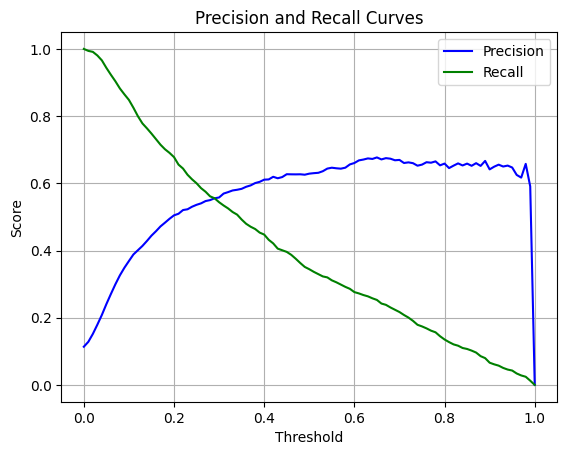

Precision and recall intersect at threshold: 0.290


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming y_val is a NumPy array with string labels
# Step 1: Convert 'yes'/'no' labels to 1/0 using NumPy
y_val_binary = np.where(y_val == 'yes', 1, 0)

# Step 2: Get the predicted probabilities on the validation dataset
y_pred_prob = model.predict_proba(X_val)[:, 1]

# Step 3: Initialize lists to store precision and recall values for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_list = []
recall_list = []

# Step 4: Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)  # Binarize the predictions at the threshold
    precision = precision_score(y_val_binary, y_pred_threshold)
    recall = recall_score(y_val_binary, y_pred_threshold)
    
    precision_list.append(precision)
    recall_list.append(recall)

# Step 5: Plot precision and recall curves
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Find the threshold where precision and recall intersect
precision_array = np.array(precision_list)
recall_array = np.array(recall_list)
intersection_index = np.argwhere(np.isclose(precision_array, recall_array, atol=0.01)).flatten()

if len(intersection_index) > 0:
    intersection_threshold = thresholds[intersection_index[0]]
    print(f'Precision and recall intersect at threshold: {intersection_threshold:.3f}')
else:
    print('No intersection found')


In [24]:
# Additional code to find the closest specified threshold
specified_thresholds = np.array([0.265, 0.465, 0.665, 0.865])
closest_threshold = specified_thresholds[np.argmin(np.abs(specified_thresholds - intersection_threshold))]

print(f'The closest specified threshold to the intersection is: {closest_threshold:.3f}')


The closest specified threshold to the intersection is: 0.265


C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


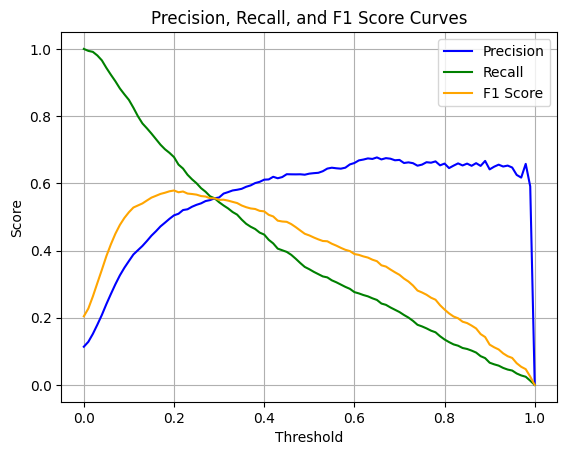

The threshold at which F1 score is maximal: 0.20


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Get the predicted probabilities on the validation dataset
y_pred_prob = model.predict_proba(X_val)[:, 1]

# Step 2: Initialize lists to store precision, recall, and F1 values for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_list = []
recall_list = []
f1_list = []

# Step 3: Calculate precision, recall, and F1 for each threshold
for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)  # Binarize the predictions at the threshold
    precision = precision_score(y_val_binary, y_pred_threshold)
    recall = recall_score(y_val_binary, y_pred_threshold)
    f1 = f1_score(y_val_binary, y_pred_threshold)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Step 4: Plot precision, recall, and F1 score curves
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='green')
plt.plot(thresholds, f1_list, label='F1 Score', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score Curves')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Find the threshold where F1 score is maximized
max_f1_index = np.argmax(f1_list)
max_f1_threshold = thresholds[max_f1_index]

print(f'The threshold at which F1 score is maximal: {max_f1_threshold:.2f}')


In [35]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming df_full_train is your full training dataframe
# Separate features and target variable
X_full = df_train.drop(columns='y')  # Replace 'y' with your actual target column name
y_full = df_train['y'].map({'yes': 1, 'no': 0})  # Convert to binary

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Drop first to avoid multicollinearity

# Set up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize list to store AUC scores
auc_scores = []

# Iterate over the folds
for train_index, val_index in kf.split(X_full):
    X_train, X_val = X_full.iloc[train_index], X_full.iloc[val_index]
    y_train, y_val = y_full.iloc[train_index], y_full.iloc[val_index]
    
    # One-hot encode the categorical variables
    X_train_encoded = encoder.fit_transform(X_train)
    X_val_encoded = encoder.transform(X_val)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict_proba(X_val_encoded)[:, 1]
    auc = roc_auc_score(y_val, y_pred_prob)
    auc_scores.append(auc)

# Calculate the standard deviation of the AUC scores
std_dev_auc = np.std(auc_scores)

# Output the standard deviation
print(f'Standard deviation of AUC scores across folds: {std_dev_auc:.4f}')


C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 11, 12] during transform. These unknown categories will be en

Standard deviation of AUC scores across folds: 0.0070


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

# Assuming df_full_train is already defined with the relevant columns and target variable



# Separate features and target variable
X_full = df_train.drop(columns='y')  # Features
y_full = df_train['y']  # Target variable

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Ignore unknown categories

# Define the C values to iterate over
C_values = [0.000001, 0.001, 1]

# Set up KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize list to store results
results = []

# Iterate over each C value
for C in C_values:
    auc_scores = []
    
    # Iterate over the folds
    for train_index, val_index in kf.split(X_full):
        X_train, X_val = X_full.iloc[train_index], X_full.iloc[val_index]
        y_train, y_val = y_full.iloc[train_index], y_full.iloc[val_index]
        
        # One-hot encode the categorical variables
        X_train_encoded = encoder.fit_transform(X_train)
        X_val_encoded = encoder.transform(X_val)
        
        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train)
        
        # Predict probabilities and calculate AUC
        y_pred_prob = model.predict_proba(X_val_encoded)[:, 1]
        auc = roc_auc_score(y_val, y_pred_prob)
        auc_scores.append(auc)
    
    # Calculate mean and standard deviation of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store results
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['C', 'Mean AUC', 'Std AUC'])

# Find the best C value based on the criteria
best_result = results_df.loc[results_df['Mean AUC'].idxmax()]

# Print the results
print(results_df)
print(f'Best C value: {best_result["C"]}, Mean AUC: {best_result["Mean AUC"]}, Std AUC: {best_result["Std AUC"]}')


C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\izkid\anaconda3\envs\ml-zoomcamp\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 9, 11, 12] during transform. These unknown categories will be en

          C  Mean AUC  Std AUC
0  0.000001     0.698    0.008
1  0.001000     0.727    0.008
2  1.000000     0.872    0.007
Best C value: 1.0, Mean AUC: 0.872, Std AUC: 0.007
